In [35]:
!pip install openpyxl
import pandas as pd
import numpy as np
df = pd.read_excel('storedata_total.xlsx')
df.head()

,custid,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,favday,city
0,6H6T6N,0,2012-09-28,2013-08-11 00:00:00,2013-08-11 00:00:00,29,100.000000,3.448276,14.52,0.000000,0,0,0,Monday,DEL
1,APCENR,1,2010-12-19,2011-04-01 00:00:00,2014-01-19 00:00:00,95,92.631579,10.526316,83.69,0.181641,1,1,1,Friday,DEL
2,7UP6MS,0,2010-10-03,2010-12-01 00:00:00,2011-07-06 00:00:00,0,0.000000,0.000000,33.58,0.059908,0,0,0,Wednesday,DEL
3,7ZEW8G,0,2010-10-22,2011-03-28 00:00:00,2011-03-28 00:00:00,0,0.000000,0.000000,54.96,0.000000,0,0,0,Thursday,BOM
4,8V726M,1,2010-11-27,2010-11-29 00:00:00,2013-01-28 00:00:00,30,90.000000,13.333333,111.91,0.008850,0,0,0,Monday,BOM


In [36]:
# Basic dataset info
print(f'Dataset shape: {df.shape}')
print(f'Churn rate: {(df.retained == 0).mean():.2%}')
print(f'Missing values: {df.isnull().sum().sum()}')
df.info()

Dataset shape: (30801, 15)
Churn rate: 20.55%
Missing values: 80
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30801 entries, 0 to 30800
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   custid      30781 non-null  object        
 1   retained    30801 non-null  int64         
 2   created     30781 non-null  datetime64[ns]
 3   firstorder  30781 non-null  object        
 4   lastorder   30781 non-null  object        
 5   esent       30801 non-null  int64         
 6   eopenrate   30801 non-null  float64       
 7   eclickrate  30801 non-null  float64       
 8   avgorder    30801 non-null  float64       
 9   ordfreq     30801 non-null  float64       
 10  paperless   30801 non-null  int64         
 11  refill      30801 non-null  int64         
 12  doorstep    30801 non-null  int64         
 13  favday      30801 non-null  object        
 14  city        30801 non-null  object        
dtypes: da

In [37]:
# Feature engineering
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Convert dates with error handling
df['firstorder'] = pd.to_datetime(df['firstorder'], errors='coerce')
df['lastorder'] = pd.to_datetime(df['lastorder'], errors='coerce')
df['created'] = pd.to_datetime(df['created'], errors='coerce')

# Create new features (handle NaT values)
df['days_since_first_order'] = (pd.Timestamp.now() - df['firstorder']).dt.days.fillna(0)
df['customer_lifespan_days'] = (df['lastorder'] - df['firstorder']).dt.days.fillna(0)
df['is_single_purchase'] = (df['customer_lifespan_days'] == 0).astype(int)
df['account_age'] = (pd.Timestamp.now() - df['created']).dt.days.fillna(0)

# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=['favday', 'city'], drop_first=True)

# Select features for modeling
feature_cols = ['esent', 'eopenrate', 'eclickrate', 'avgorder', 'ordfreq', 
               'paperless', 'refill', 'doorstep', 'days_since_first_order', 
               'account_age', 'is_single_purchase'] + [col for col in df_encoded.columns if col.startswith(('favday_', 'city_'))]


X = df_encoded[feature_cols].fillna(0)
y = df_encoded['retained']
print(f'Features: {len(feature_cols)}')


Features: 20


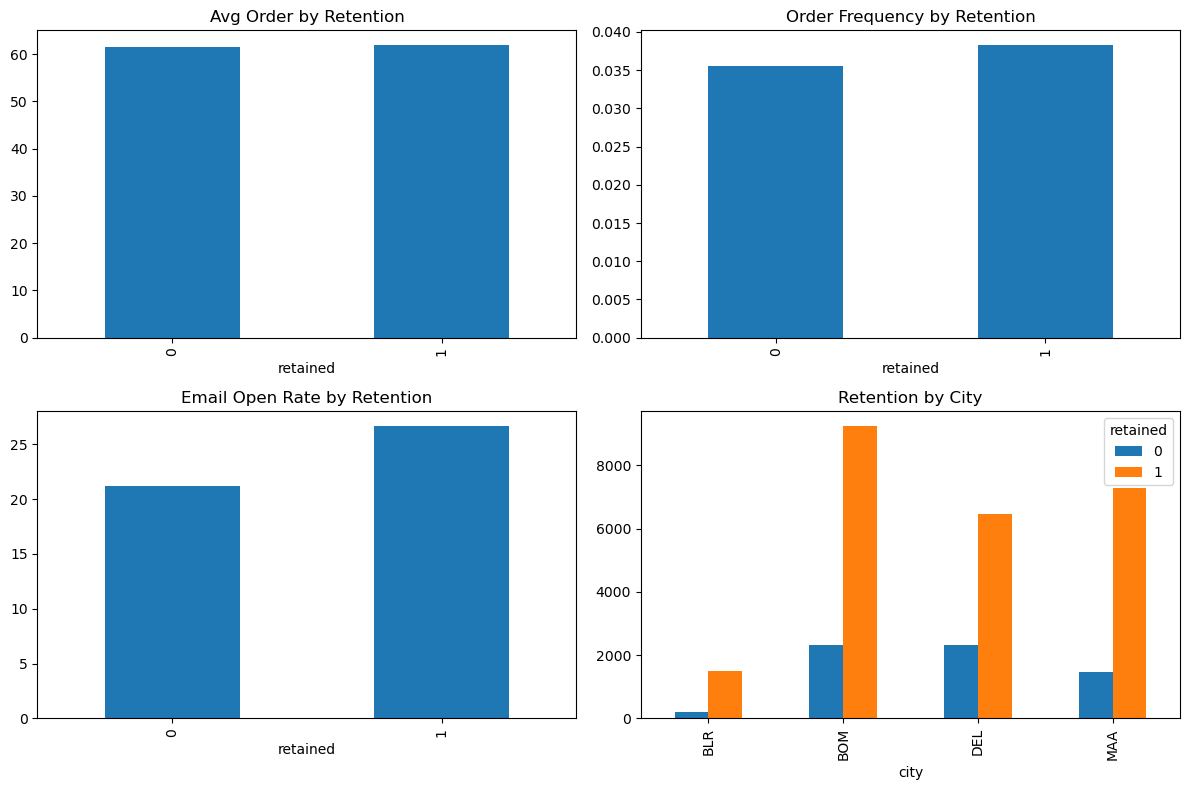

In [38]:
# Churn analysis visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Churn by key features
df.groupby('retained')['avgorder'].mean().plot(kind='bar', ax=axes[0,0], title='Avg Order by Retention')
df.groupby('retained')['ordfreq'].mean().plot(kind='bar', ax=axes[0,1], title='Order Frequency by Retention')
df.groupby('retained')['eopenrate'].mean().plot(kind='bar', ax=axes[1,0], title='Email Open Rate by Retention')
df.groupby(['city', 'retained']).size().unstack().plot(kind='bar', ax=axes[1,1], title='Retention by City')

plt.tight_layout()
plt.show()

In [39]:
# Model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
lr = LogisticRegression(random_state=42, max_iter=1000)

rf.fit(X_train, y_train)
lr.fit(X_train_scaled, y_train)

# Predictions
rf_pred = rf.predict(X_test)
lr_pred = lr.predict(X_test_scaled)

# Evaluation
print('Random Forest Results:')
print(f'AUC: {roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]):.3f}')
print(classification_report(y_test, rf_pred))

print('\nLogistic Regression Results:')
print(f'AUC: {roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:, 1]):.3f}')
print(classification_report(y_test, lr_pred))

Random Forest Results:
AUC: 0.979
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1266
           1       0.97      0.99      0.98      4895

    accuracy                           0.97      6161
   macro avg       0.96      0.93      0.95      6161
weighted avg       0.97      0.97      0.97      6161


Logistic Regression Results:
AUC: 0.968
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1266
           1       0.96      0.97      0.96      4895

    accuracy                           0.94      6161
   macro avg       0.91      0.90      0.91      6161
weighted avg       0.94      0.94      0.94      6161



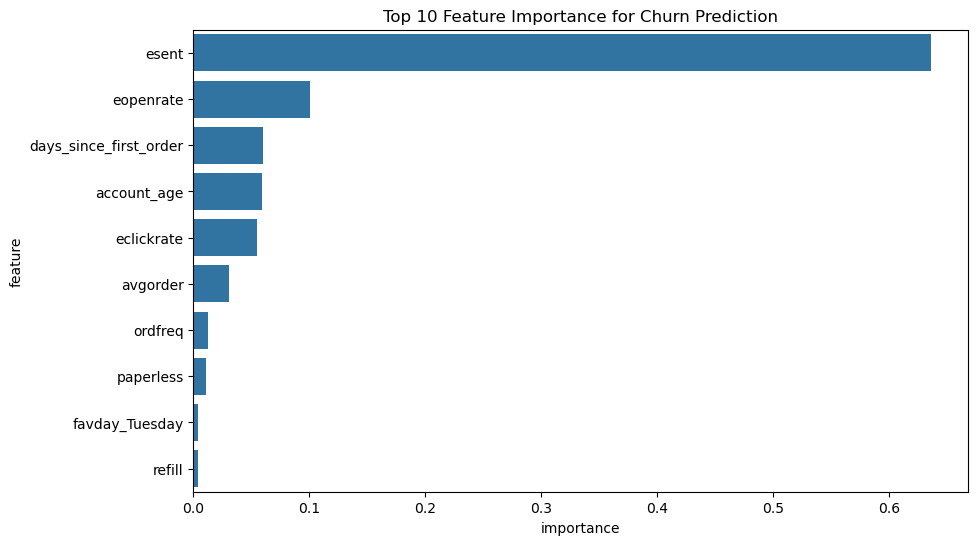

Top 5 most important features:
                  feature  importance
0                   esent    0.636528
1               eopenrate    0.100230
8  days_since_first_order    0.060176
9             account_age    0.058998
2              eclickrate    0.054555


In [40]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importance for Churn Prediction')
plt.show()

print('Top 5 most important features:')
print(feature_importance.head())

# Chrun analysis for multi-purchase customers

In [41]:

# Filter to multi-purchase customers only
multi_purchase_df = df[df['customer_lifespan_days'] > 0].copy()

print(f"Original dataset: {len(df)} customers")
print(f"Multi-purchase customers: {len(multi_purchase_df)} customers")
print(f"Churn rate (multi-purchase): {(multi_purchase_df['retained'] == 0).mean():.2%}")


Original dataset: 30801 customers
Multi-purchase customers: 11773 customers
Churn rate (multi-purchase): 19.32%


In [42]:
# Encode categorical variables
df_encoded = pd.get_dummies(multi_purchase_df, columns=['favday', 'city'], drop_first=True)

# Select features for modeling
feature_cols = ['esent', 'eopenrate', 'eclickrate', 'avgorder', 'ordfreq', 
               'paperless', 'refill', 'doorstep', 'days_since_first_order', 
               'account_age', 'is_single_purchase'] + [col for col in df_encoded.columns if col.startswith(('favday_', 'city_'))]


X = df_encoded[feature_cols].fillna(0)
y = df_encoded['retained']
print(f'Features: {len(feature_cols)}')

Features: 20


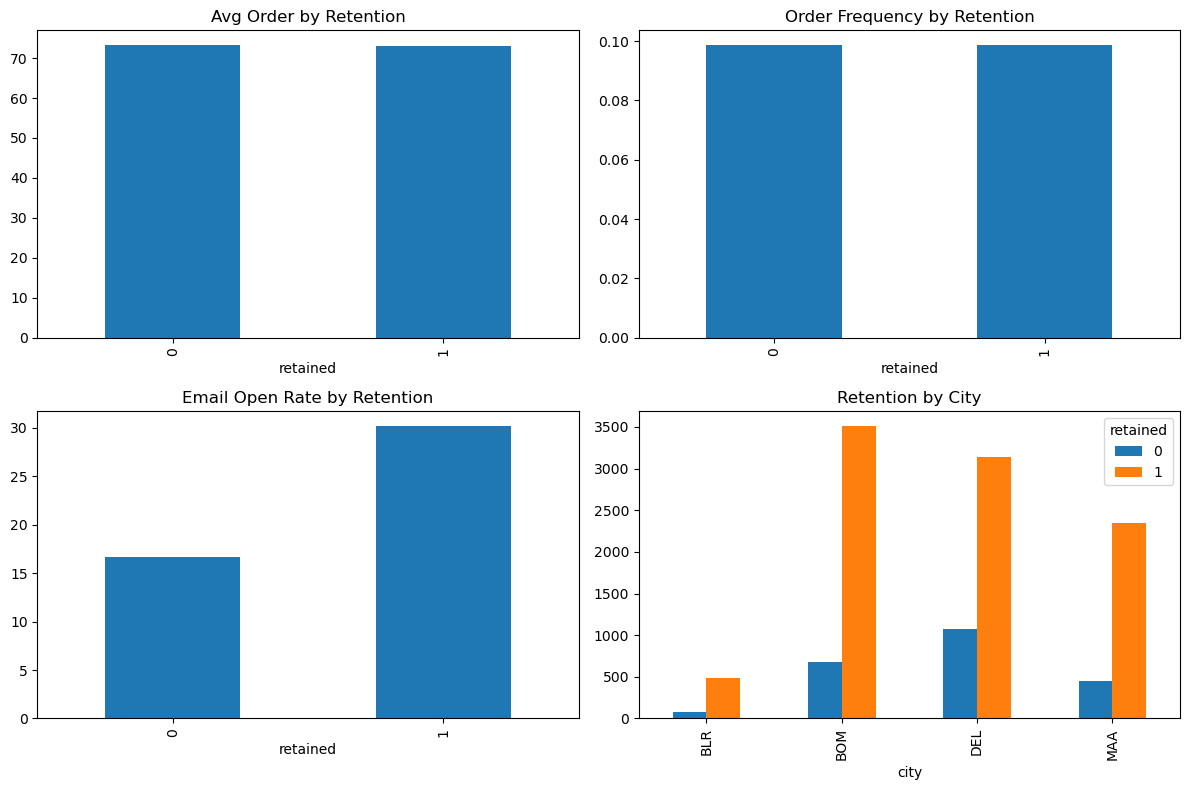

In [43]:
# Churn analysis visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Churn by key features
multi_purchase_df.groupby('retained')['avgorder'].mean().plot(kind='bar', ax=axes[0,0], title='Avg Order by Retention')
multi_purchase_df.groupby('retained')['ordfreq'].mean().plot(kind='bar', ax=axes[0,1], title='Order Frequency by Retention')
multi_purchase_df.groupby('retained')['eopenrate'].mean().plot(kind='bar', ax=axes[1,0], title='Email Open Rate by Retention')
multi_purchase_df.groupby(['city', 'retained']).size().unstack().plot(kind='bar', ax=axes[1,1], title='Retention by City')

plt.tight_layout()
plt.show()

In [44]:
# Model training and evaluation

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
lr = LogisticRegression(random_state=42, max_iter=1000)

rf.fit(X_train, y_train)
lr.fit(X_train_scaled, y_train)

# Predictions
rf_pred = rf.predict(X_test)
lr_pred = lr.predict(X_test_scaled)

# Evaluation
print('Random Forest Results:')
print(f'AUC: {roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]):.3f}')
print(classification_report(y_test, rf_pred))

print('\nLogistic Regression Results:')
print(f'AUC: {roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:, 1]):.3f}')
print(classification_report(y_test, lr_pred))

Random Forest Results:
AUC: 0.980
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       455
           1       0.97      0.99      0.98      1900

    accuracy                           0.97      2355
   macro avg       0.97      0.94      0.96      2355
weighted avg       0.97      0.97      0.97      2355


Logistic Regression Results:
AUC: 0.979
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       455
           1       0.97      0.99      0.98      1900

    accuracy                           0.97      2355
   macro avg       0.96      0.93      0.94      2355
weighted avg       0.97      0.97      0.97      2355



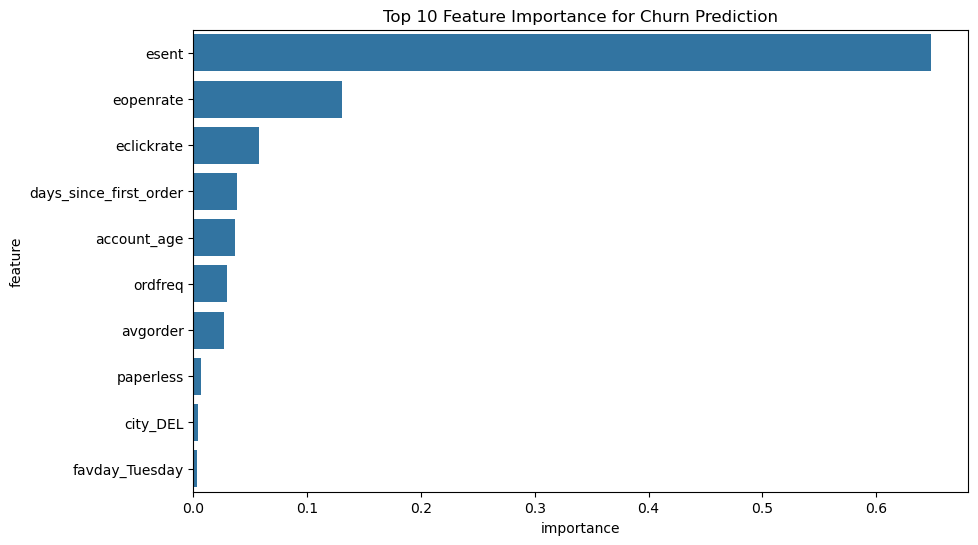

Top 5 most important features:
                  feature  importance
0                   esent    0.648676
1               eopenrate    0.130309
2              eclickrate    0.057538
8  days_since_first_order    0.038347
9             account_age    0.036500


In [45]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importance for Churn Prediction')
plt.show()

print('Top 5 most important features:')
print(feature_importance.head())

Key Notes:

Email Engagement is THE Churn Driver

Nearly 84% of your model's prediction power comes from email metrics
This is an incredibly strong signal for business strategy

97%+ accuracy in predicting which customers will churn
Multi-purchase filtering creates cleaner, more actionable predictions
Focus on engaged customers yields better model performance
Winner: Random Forest on multi-purchase customers (AUC: 0.980)

# SageMaker AutoML for Churn Prediction

In [46]:
import boto3
import sagemaker
from sagemaker.automl.automl import AutoML
from datetime import datetime

# Setup
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()

# Using  multi-purchase filtered dataset

automl_data = df_encoded[feature_cols + ['retained']].fillna(0)

# Save to shared folder instead of S3
timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
local_path = f'train-{timestamp}.csv'
automl_data.to_csv(local_path, index=False)


# Create AutoML job
automl = AutoML(
    role=role,
    target_attribute_name='retained',
    sagemaker_session=sagemaker_session,
    max_candidates=15,
    max_runtime_per_training_job_in_seconds=1800
)

# Start job
job_name = f'churn-automl-{timestamp}'
#automl.fit(train_path, job_name=job_name, wait=False)

print(f"✅ AutoML job '{job_name}' started!")
print(f"📊 Testing 15+ algorithms: XGBoost, Random Forest, Linear Learner, etc.")
print(f"🔗 Monitor: https://console.aws.amazon.com/sagemaker/home#/automl-jobs/{job_name}")
print(f"⏱️ Estimated completion: ~1 hour")

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
sagemaker.config INFO - Applied value from config key = SageMaker.AutoMLJob.AutoMLJobConfig.SecurityConfig.VpcConfig
✅ AutoML job 'churn-automl-20251231-163832' started!
📊 Testing 15+ algorithms: XGBoost, Random Forest, Linear Learner, etc.
🔗 Monitor: https://console.aws.amazon.com/sagemaker/home#/automl-jobs/churn-automl-20251231-163832
⏱️ Estimated completion: ~1 hour


In [47]:

sm_client = boto3.client('sagemaker')

# List recent AutoML jobs
jobs = sm_client.list_auto_ml_jobs(SortBy='CreationTime', SortOrder='Descending')

for job in jobs['AutoMLJobSummaries'][:5]:
    print(f"Job: {job['AutoMLJobName']}")
    print(f"Status: {job['AutoMLJobStatus']}")
    print(f"Created: {job['CreationTime']}")
    print("---")


Job: automl-2025-12-30-20-45-26-242
Status: Completed
Created: 2025-12-30 20:45:26.994000+00:00
---
Job: churn-automl-20251230-194043
Status: Failed
Created: 2025-12-30 19:40:44.717000+00:00
---


In [48]:

sm_client = boto3.client('sagemaker')
job_name = 'automl-2025-12-30-20-45-26-242'

# Get job details and best candidate
job_details = sm_client.describe_auto_ml_job(AutoMLJobName=job_name)
best_candidate = job_details['BestCandidate']

print(f"Best Model: {best_candidate['CandidateName']}")
print(f"Objective Metric: {best_candidate['FinalAutoMLJobObjectiveMetric']['MetricName']}: {best_candidate['FinalAutoMLJobObjectiveMetric']['Value']:.4f}")

# Get top 5 candidates
candidates = sm_client.list_candidates_for_auto_ml_job(AutoMLJobName=job_name)
print("\nTop 5 Models:")
for i, candidate in enumerate(candidates['Candidates'][:5]):
    metric = candidate['FinalAutoMLJobObjectiveMetric']
    print(f"Rank {i+1}: {candidate['CandidateName']} - {metric['MetricName']}: {metric['Value']:.4f}")


Best Model: automl-2025-12-30-20-45-26-242Kf-001-763abc66
Objective Metric: validation:f1_binary: 0.9435

Top 5 Models:
Rank 1: automl-2025-12-30-20-45-26-242Kf-015-90b9a3e8 - validation:f1_binary: 0.9149
Rank 2: automl-2025-12-30-20-45-26-242Kf-014-0384e3a4 - validation:f1_binary: 0.9333
Rank 3: automl-2025-12-30-20-45-26-242Kf-013-a58ac128 - validation:f1_binary: 0.9366
Rank 4: automl-2025-12-30-20-45-26-242Kf-011-cd16eb02 - validation:f1_binary: 0.9312
Rank 5: automl-2025-12-30-20-45-26-242Kf-012-3236ce4c - validation:f1_binary: 0.9308


In [56]:
# Get the actual algorithm used by AutoML
try:
    # Try to get algorithm from candidate steps
    candidate_steps = best_candidate.get('CandidateSteps', [])
    for step in candidate_steps:
        if step['CandidateStepType'] == 'AWS::SageMaker::TrainingJob':
            algorithm_spec = step.get('CandidateStepArn', '')
            break
    
    # Parse candidate name for algorithm hints
    candidate_name = best_candidate['CandidateName']
    
    # Common AutoML algorithms mapping
    if 'rf' in candidate_name.lower() or 'forest' in candidate_name.lower():
        algorithm = "Random Forest"
    elif 'gb' in candidate_name.lower() or 'boost' in candidate_name.lower():
        algorithm = "Gradient Boosting"
    elif 'lr' in candidate_name.lower() or 'linear' in candidate_name.lower():
        algorithm = "Logistic Regression"
    elif 'svm' in candidate_name.lower():
        algorithm = "Support Vector Machine"
    elif 'nb' in candidate_name.lower():
        algorithm = "Naive Bayes"
    else:
        algorithm = "Scikit-Learn AutoML (Best Algorithm Auto-Selected)"
        
except:
    algorithm = "Scikit-Learn AutoML"

print(f"Best Model Algorithm: {algorithm}")
print(f"Container: sagemaker-sklearn-automl")
print(f"Model Name: {best_candidate['CandidateName']}")
print(f"F1 Score: {best_candidate['FinalAutoMLJobObjectiveMetric']['Value']:.4f}")


Best Model Algorithm: Scikit-Learn AutoML (Best Algorithm Auto-Selected)
Container: sagemaker-sklearn-automl
Model Name: automl-2025-12-30-20-45-26-242Kf-001-763abc66
F1 Score: 0.9435


# Model deployed using console
# https://us-east-2.console.aws.amazon.com/sagemaker/home?region=us-east-2#/endpoints/churn-prediction-endpoint

# Testing

In [52]:
runtime = boto3.client('sagemaker-runtime', region_name='us-east-2')

# Convert boolean values to integers
test_data = df_encoded[feature_cols].fillna(0).iloc[0]
test_data = test_data.astype(float)  # Convert all to float
test_csv = ','.join([str(x) for x in test_data.values])

response = runtime.invoke_endpoint(
    EndpointName='churn-prediction-endpoint',
    ContentType='text/csv',
    Body=test_csv
)

result = response['Body'].read().decode()
print(f"Prediction: {result}")
print(f"Actual: {df_encoded.iloc[0]['retained']}")

Prediction: 0.00040601633372716606

Actual: 1


In [58]:
# Test multiple customers
for i in range(20):
    test_data = df_encoded[feature_cols].fillna(0).iloc[i].astype(float)
    test_csv = ','.join([str(x) for x in test_data.values])
    
    response = runtime.invoke_endpoint(
        EndpointName='churn-prediction-endpoint',
        ContentType='text/csv',
        Body=test_csv
    )
    
    result = float(response['Body'].read().decode())
    actual = df_encoded.iloc[i]['retained']

    if result > 0.7:
        action = "🔴 URGENT: Personal call + discount"
    elif result > 0.3:
        action = "🟡 Send targeted email campaign"
    else:
        action = "🟢 Continue regular engagement"
    
    print(f"Customer {i+1}: Churn Risk={result:.4f}, Actual={'Retained' if actual==1 else 'Churned'}, Action: {action}")

Customer 1: Churn Risk=0.0004, Actual=Retained, Action: 🟢 Continue regular engagement
Customer 2: Churn Risk=0.4532, Actual=Churned, Action: 🟡 Send targeted email campaign
Customer 3: Churn Risk=0.0004, Actual=Retained, Action: 🟢 Continue regular engagement
Customer 4: Churn Risk=0.0004, Actual=Retained, Action: 🟢 Continue regular engagement
Customer 5: Churn Risk=0.0005, Actual=Retained, Action: 🟢 Continue regular engagement
Customer 6: Churn Risk=0.0004, Actual=Retained, Action: 🟢 Continue regular engagement
Customer 7: Churn Risk=0.0004, Actual=Retained, Action: 🟢 Continue regular engagement
Customer 8: Churn Risk=0.0003, Actual=Retained, Action: 🟢 Continue regular engagement
Customer 9: Churn Risk=0.0005, Actual=Retained, Action: 🟢 Continue regular engagement
Customer 10: Churn Risk=0.0003, Actual=Retained, Action: 🟢 Continue regular engagement
Customer 11: Churn Risk=0.0005, Actual=Retained, Action: 🟢 Continue regular engagement
Customer 12: Churn Risk=0.0004, Actual=Churned, Acti